In [1]:
import sys

# Check if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("📍 Running in Google Colab")
    print("\n📦 Installing required packages...")
    # Install packages not pre-installed in Colab
    !pip install -q xgboost lightgbm shap
    print("✅ Packages installed successfully!")
    print("\n📂 Next step: Upload dataset or use Kaggle API")
    print(" See COLAB_SETUP_GUIDE.md for three dataset loading options:")
    print(" - Option A: Direct upload from computer")
    print(" - Option B: Kaggle API download")
    print(" - Option C: Google Drive mount")
else:
    print("💻 Running locally")
    print("✅ Using local file paths and environment")


📍 Running in Google Colab

📦 Installing required packages...
✅ Packages installed successfully!

📂 Next step: Upload dataset or use Kaggle API
 See COLAB_SETUP_GUIDE.md for three dataset loading options:
 - Option A: Direct upload from computer
 - Option B: Kaggle API download
 - Option C: Google Drive mount


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# If running locally (Jupyter/Lab), set the path to your CSV
filename = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'  # adjust as needed
import pandas as pd
data = pd.read_csv(filename)
print('Loaded:', filename, 'Shape:', data.shape)



Loaded: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv Shape: (7043, 21)


In [3]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())


In [4]:
project_charter = {
    'stakeholders': ['VP Customer Success', 'Retention Analytics Lead', 'Data Engineering'],
    'business_objectives': ['Quantify churn risk', 'Prioritize outreach campaigns'],
    'constraints': ['Data refresh monthly', 'Model must be explainable'],
    'milestones': {
        'kickoff': 'Define outcomes and KPIs',
        'baseline_model': 'First iteration with classical ML',
        'deployment_candidate': 'Pipeline validated in UAT'
    }
}
project_charter


{'stakeholders': ['VP Customer Success',
  'Retention Analytics Lead',
  'Data Engineering'],
 'business_objectives': ['Quantify churn risk',
  'Prioritize outreach campaigns'],
 'constraints': ['Data refresh monthly', 'Model must be explainable'],
 'milestones': {'kickoff': 'Define outcomes and KPIs',
  'baseline_model': 'First iteration with classical ML',
  'deployment_candidate': 'Pipeline validated in UAT'}}

In [5]:
summary = data.describe(include='all').transpose()
summary[['count', 'unique', 'top', 'freq']].head(10)


,count,unique,top,freq
customerID,7043,7043,3186-AJIEK,1
gender,7043,2,Male,3555
SeniorCitizen,7043.0,NaN,NaN,NaN
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
tenure,7043.0,NaN,NaN,NaN
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498


Churn distribution:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


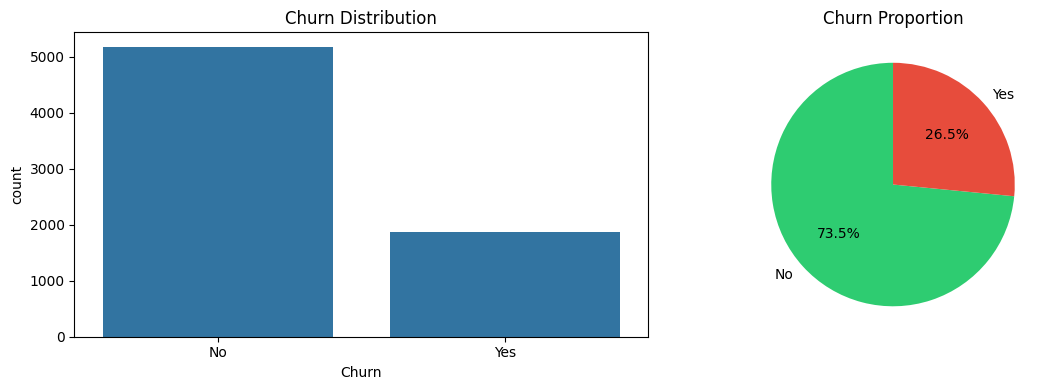


Class Imbalance Ratio: 2.77:1


In [6]:
churn_rate = data['Churn'].value_counts(normalize=True)
print('Churn distribution:\n', churn_rate)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=data, x='Churn', ax=ax[0])
ax[0].set_title('Churn Distribution')

# Class imbalance visualization
churn_counts = data['Churn'].value_counts()
# Ensure labels map to index order
labels = churn_counts.index.tolist()
ax[1].pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
ax[1].set_title('Churn Proportion')
plt.tight_layout()
plt.show()

# Safely compute ratio if Yes present
if 'Yes' in churn_counts and churn_counts['Yes'] > 0:
    ratio = churn_counts.get('No', 0) / churn_counts['Yes']
    print(f'\nClass Imbalance Ratio: {ratio:.2f}:1')


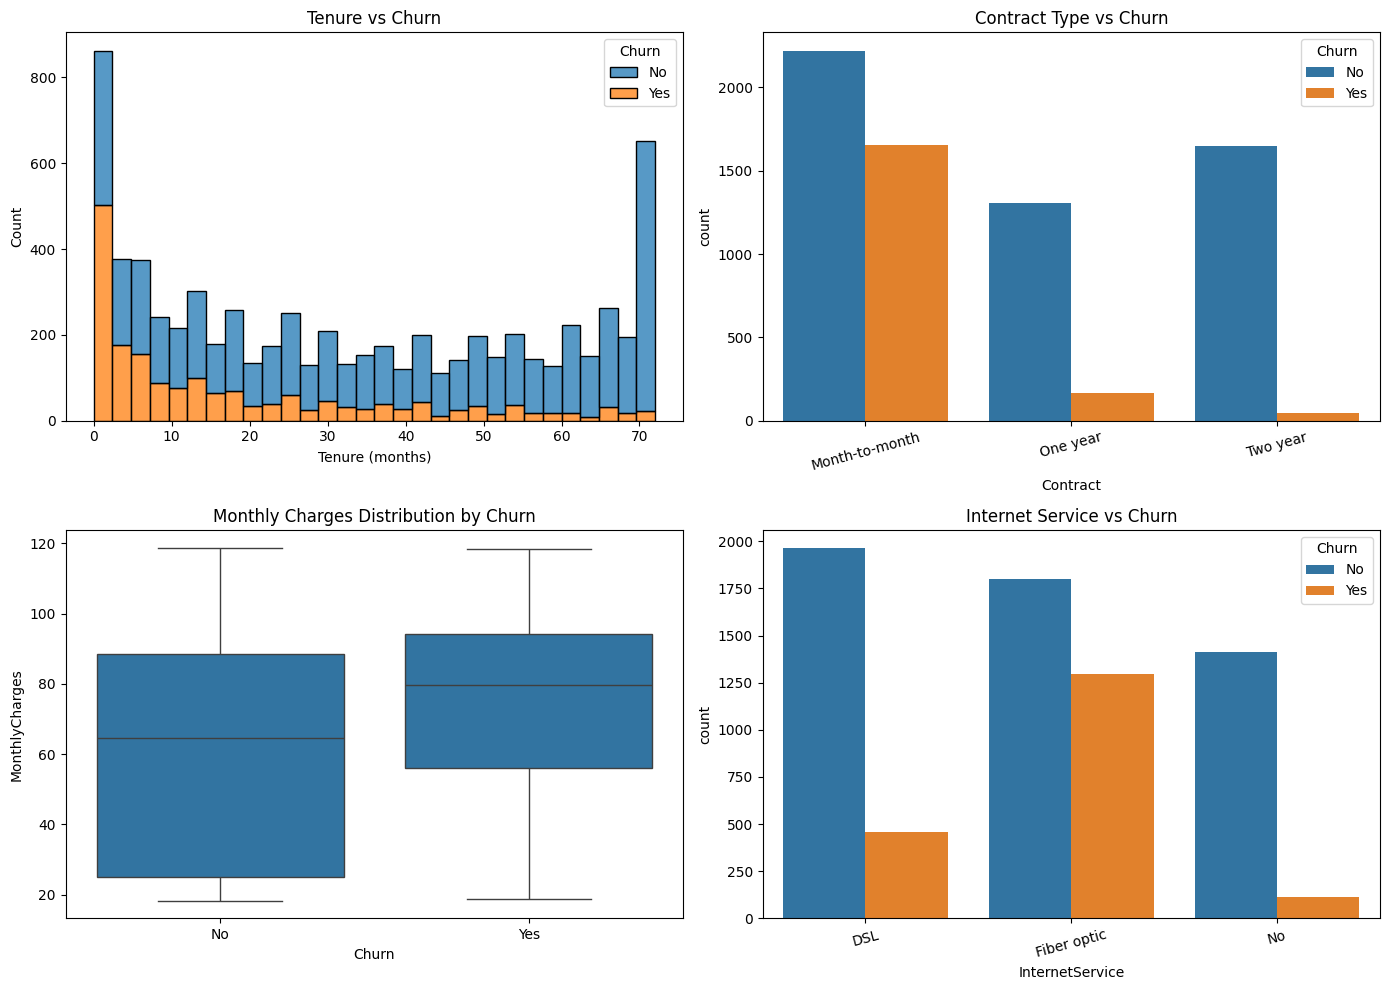


=== Churn Rates by Key Features ===

Contract:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64

InternetService:
InternetService
Fiber optic    41.892765
DSL            18.959108
No              7.404980
Name: Churn, dtype: float64

PaymentMethod:
PaymentMethod
Electronic check             45.285412
Mailed check                 19.106700
Bank transfer (automatic)    16.709845
Credit card (automatic)      15.243101
Name: Churn, dtype: float64


In [7]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Tenure vs Churn
sns.histplot(data=data, x='tenure', hue='Churn', multiple='stack', ax=ax[0, 0], bins=30)
ax[0, 0].set_title('Tenure vs Churn')
ax[0, 0].set_xlabel('Tenure (months)')

# Contract Type vs Churn
sns.countplot(data=data, x='Contract', hue='Churn', ax=ax[0, 1])
ax[0, 1].set_title('Contract Type vs Churn')
ax[0, 1].tick_params(axis='x', rotation=15)

# Monthly Charges vs Churn
sns.boxplot(data=data, x='Churn', y='MonthlyCharges', ax=ax[1, 0])
ax[1, 0].set_title('Monthly Charges Distribution by Churn')

# Internet Service vs Churn
sns.countplot(data=data, x='InternetService', hue='Churn', ax=ax[1, 1])
ax[1, 1].set_title('Internet Service vs Churn')
ax[1, 1].tick_params(axis='x', rotation=15)

fig.tight_layout()
plt.show()

# Churn rate by key categories
print('\n=== Churn Rates by Key Features ===')
for col in ['Contract', 'InternetService', 'PaymentMethod']:
    if col in data.columns:
        print(f'\n{col}:')
        churn_by_cat = data.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
        print(churn_by_cat.sort_values(ascending=False))


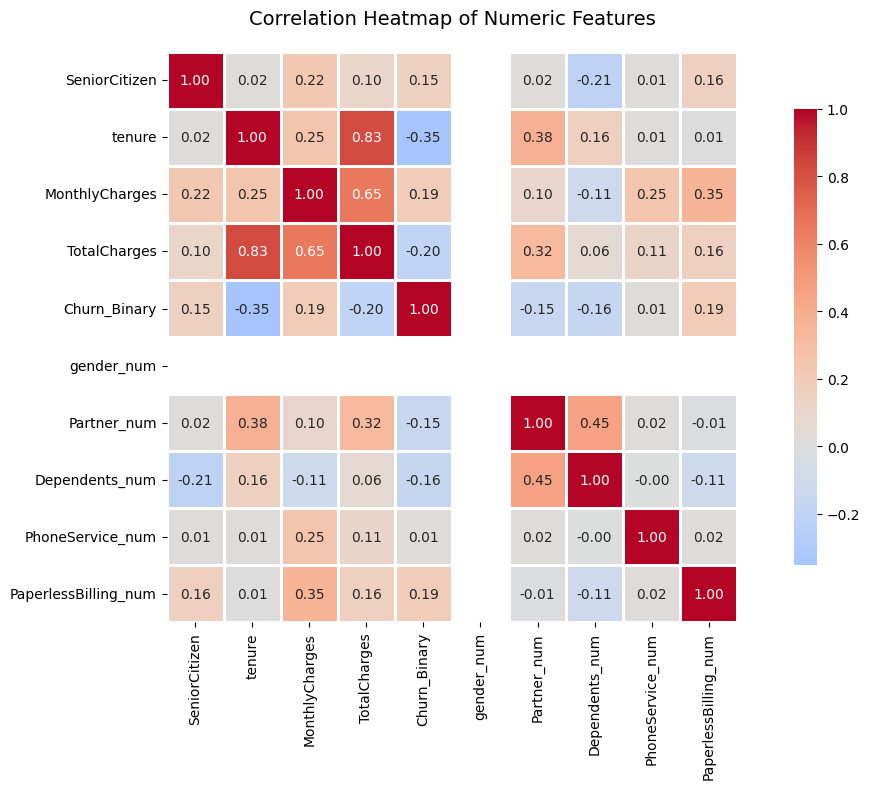


=== Features Most Correlated with Churn ===
tenure                  0.352229
TotalCharges            0.199037
MonthlyCharges          0.193356
PaperlessBilling_num    0.191825
Dependents_num          0.164221
SeniorCitizen           0.150889
Partner_num             0.150448
PhoneService_num        0.011942
Name: Churn_Binary, dtype: float64


In [8]:
# Create numeric version of dataset for correlation analysis
data_numeric = data.copy()
data_numeric['Churn_Binary'] = (data['Churn'] == 'Yes').astype(int)

# Convert categorical "Yes/No" where meaningful
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col in data_numeric.columns:
        data_numeric[f'{col}_num'] = (data_numeric[col] == 'Yes').astype(int)

# Select numeric columns for correlation
numeric_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary'] + \
    [f'{col}_num' for col in binary_cols if col in data_numeric.columns]

correlation_matrix = data_numeric[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Top correlations with churn
print('\n=== Features Most Correlated with Churn ===')
churn_corr = correlation_matrix['Churn_Binary'].drop('Churn_Binary').abs().sort_values(ascending=False)
print(churn_corr.head(8))


In [9]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
missing_total = data['TotalCharges'].isna().sum()
print(f'TotalCharges missing: {missing_total}')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())


TotalCharges missing: 0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

target = 'Churn'
X = data.drop(columns=[target, 'customerID'])
y = data[target].map({'No': 0, 'Yes': 1})

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocess = ColumnTransformer(transformers=[
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols)
])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)
X_train.shape, X_valid.shape, X_test.shape


((4930, 19), (1056, 19), (1057, 19))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

log_reg = Pipeline(steps=[('prep', preprocess), ('model', LogisticRegression(max_iter=1000))])
log_reg.fit(X_train, y_train)
valid_preds = log_reg.predict(X_valid)
valid_proba = log_reg.predict_proba(X_valid)[:, 1]
print(classification_report(y_valid, valid_preds))
print('Validation ROC-AUC:', roc_auc_score(y_valid, valid_proba))


              precision    recall  f1-score   support

           0       0.86      0.88      0.87       776
           1       0.65      0.59      0.62       280

    accuracy                           0.81      1056
   macro avg       0.75      0.74      0.74      1056
weighted avg       0.80      0.81      0.80      1056

Validation ROC-AUC: 0.8452572717231223


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[('prep', preprocess), ('model', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42))])
rf_model.fit(X_train, y_train)
rf_valid_preds = rf_model.predict(X_valid)
rf_valid_proba = rf_model.predict_proba(X_valid)[:, 1]
print(classification_report(y_valid, rf_valid_preds))
print('Validation ROC-AUC:', roc_auc_score(y_valid, rf_valid_proba))


              precision    recall  f1-score   support

           0       0.82      0.88      0.85       776
           1       0.59      0.48      0.53       280

    accuracy                           0.77      1056
   macro avg       0.71      0.68      0.69      1056
weighted avg       0.76      0.77      0.77      1056

Validation ROC-AUC: 0.8190307437407952


In [13]:
# Install if needed in local env: pip install xgboost lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost Model
xgb_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=3,  # Handle class imbalance
        random_state=42,
        eval_metric='logloss'
    ))
])
xgb_model.fit(X_train, y_train)
xgb_valid_preds = xgb_model.predict(X_valid)
xgb_valid_proba = xgb_model.predict_proba(X_valid)[:, 1]
print('=== XGBoost Performance ===')
print(classification_report(y_valid, xgb_valid_preds))
print('Validation ROC-AUC:', roc_auc_score(y_valid, xgb_valid_proba))

# LightGBM Model
lgbm_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    ))
])
lgbm_model.fit(X_train, y_train)
lgbm_valid_preds = lgbm_model.predict(X_valid)
lgbm_valid_proba = lgbm_model.predict_proba(X_valid)[:, 1]
print('\n=== LightGBM Performance ===')
print(classification_report(y_valid, lgbm_valid_preds))
print('Validation ROC-AUC:', roc_auc_score(y_valid, lgbm_valid_proba))


=== XGBoost Performance ===
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       776
           1       0.51      0.75      0.61       280

    accuracy                           0.74      1056
   macro avg       0.70      0.74      0.71      1056
weighted avg       0.79      0.74      0.76      1056

Validation ROC-AUC: 0.8314824189985273

=== LightGBM Performance ===
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       776
           1       0.52      0.74      0.61       280

    accuracy                           0.75      1056
   macro avg       0.71      0.75      0.71      1056
weighted avg       0.79      0.75      0.76      1056

Validation ROC-AUC: 0.8323292525773196


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== Model Performance Comparison ===
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.805871   0.645914 0.592857  0.618250 0.845257
      Random Forest  0.772727   0.586957 0.482143  0.529412 0.819031
            XGBoost  0.743371   0.511002 0.746429  0.606676 0.831482
           LightGBM  0.751894   0.522843 0.735714  0.611276 0.832329


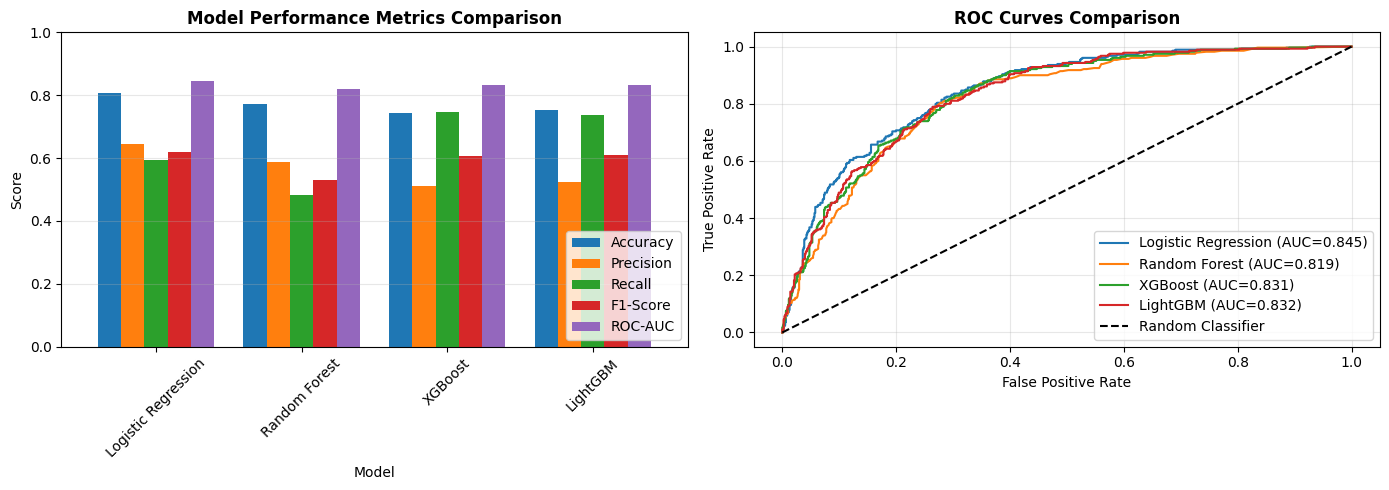


🏆 Champion Model: XGBoost (Highest Recall: 0.746)


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

# Collect all model predictions (validation set)
models_dict = {
    'Logistic Regression': (valid_preds, valid_proba),
    'Random Forest': (rf_valid_preds, rf_valid_proba),
    'XGBoost': (xgb_valid_preds, xgb_valid_proba),
    'LightGBM': (lgbm_valid_preds, lgbm_valid_proba)
}

# Calculate metrics for each model
comparison_results = []
for name, (preds, proba) in models_dict.items():
    comparison_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_valid, preds),
        'Precision': precision_score(y_valid, preds),
        'Recall': recall_score(y_valid, preds),
        'F1-Score': f1_score(y_valid, preds),
        'ROC-AUC': roc_auc_score(y_valid, proba)
    })

comparison_df = pd.DataFrame(comparison_results)
print('=== Model Performance Comparison ===')
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Metric comparison bar chart
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
comparison_df.set_index('Model')[metrics_to_plot].plot(kind='bar', ax=ax[0], width=0.8)
ax[0].set_title('Model Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Score')
ax[0].set_xlabel('Model')
ax[0].legend(loc='lower right')
ax[0].set_ylim(0, 1)
ax[0].grid(axis='y', alpha=0.3)
ax[0].tick_params(axis='x', rotation=45)

# ROC curves comparison
for name, (_, proba) in models_dict.items():
    fpr, tpr, _ = roc_curve(y_valid, proba)
    ax[1].plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_valid, proba):.3f})')

ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax[1].legend(loc='lower right')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select champion model (highest recall as per business requirement)
champion_model = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']
print(f'\n🏆 Champion Model: {champion_model} (Highest Recall: {comparison_df["Recall"].max():.3f})')


              precision    recall  f1-score   support

           0       0.82      0.91      0.86       776
           1       0.64      0.46      0.53       281

    accuracy                           0.79      1057
   macro avg       0.73      0.68      0.70      1057
weighted avg       0.77      0.79      0.77      1057

Test ROC-AUC: 0.8214151410646805


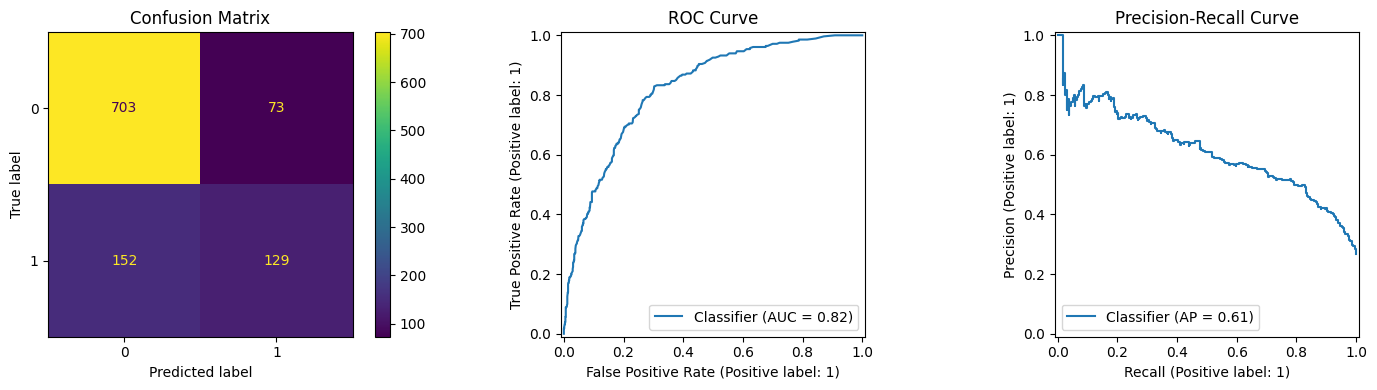

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, classification_report, roc_auc_score

# Use rf_model as the default for test evaluation; switch if another champion is chosen
test_proba = rf_model.predict_proba(X_test)[:, 1]
test_preds = (test_proba >= 0.5).astype(int)
print(classification_report(y_test, test_preds))
print('Test ROC-AUC:', roc_auc_score(y_test, test_proba))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, ax=ax[0])
ax[0].set_title('Confusion Matrix')
RocCurveDisplay.from_predictions(y_test, test_proba, ax=ax[1])
ax[1].set_title('ROC Curve')
PrecisionRecallDisplay.from_predictions(y_test, test_proba, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')
fig.tight_layout()
plt.show()


In [16]:
from pathlib import Path
from joblib import dump

artifacts_dir = Path('../app/artifacts')
artifacts_dir.mkdir(exist_ok=True, parents=True)

model_path = artifacts_dir / 'telco_churn_pipeline.joblib'
dump(rf_model, model_path)
print(f'Pipeline saved to {model_path}')


Pipeline saved to ../app/artifacts/telco_churn_pipeline.joblib


In [17]:
sample_payload = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 80.65,
    'TotalCharges': 1020.5
}
sample_payload


{'gender': 'Female',
 'SeniorCitizen': 0,
 'Partner': 'Yes',
 'Dependents': 'No',
 'tenure': 12,
 'PhoneService': 'Yes',
 'MultipleLines': 'No',
 'InternetService': 'Fiber optic',
 'OnlineSecurity': 'No',
 'OnlineBackup': 'No',
 'DeviceProtection': 'No',
 'TechSupport': 'No',
 'StreamingTV': 'Yes',
 'StreamingMovies': 'Yes',
 'Contract': 'Month-to-month',
 'PaperlessBilling': 'Yes',
 'PaymentMethod': 'Electronic check',
 'MonthlyCharges': 80.65,
 'TotalCharges': 1020.5}

In [18]:
from joblib import dump
import json
from datetime import datetime
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

artifacts_dir = Path('../app/artifacts')
artifacts_dir.mkdir(exist_ok=True, parents=True)

# Choose best model if different; default to rf_model for this example
best_model = rf_model  # Replace with champion if needed
model_path = artifacts_dir / 'telco_churn_pipeline.joblib'
dump(best_model, model_path)
print(f'✓ Pipeline saved to {model_path}')

# Save feature metadata
feature_metadata = {
    'categorical_features': [c for c in X.columns if c in X.select_dtypes(include=['object']).columns],
    'numeric_features': [c for c in X.columns if c in X.select_dtypes(exclude=['object']).columns],
    'target': target
}
with open(artifacts_dir / 'feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print('✓ Feature metadata saved')

# Build model card using test metrics computed earlier
model_card = {
    'model_name': 'Telco Customer Churn Predictor',
    'version': '1.0.0',
    'created_date': datetime.now().isoformat(),
    'methodology': 'CRISP-DM',
    'algorithm': 'Random Forest Classifier',  # Update if champion differs
    'training_data': {
        'source': 'Kaggle - Telco Customer Churn',
        'n_samples_train': len(X_train),
        'n_samples_valid': len(X_valid),
        'n_samples_test': len(X_test),
        'class_distribution': f'{(y_train == 0).sum()} No Churn, {(y_train == 1).sum()} Churn'
    },
    'performance_metrics': {
        'test_accuracy': accuracy_score(y_test, test_preds),
        'test_precision': precision_score(y_test, test_preds),
        'test_recall': recall_score(y_test, test_preds),
        'test_f1': f1_score(y_test, test_preds),
        'test_roc_auc': roc_auc_score(y_test, test_proba)
    },
    'business_requirements': {
        'primary_metric': 'Recall >= 0.80',
        'objective': 'Identify at-risk customers for retention campaigns',
        'inference_latency_target': '<150ms per prediction'
    },
    'limitations': [
        'Model trained on single telecom dataset - may not generalize to other industries',
        'Class imbalance may affect precision',
        'Requires monthly retraining as customer behavior changes',
        'Does not account for seasonality or external economic factors'
    ],
    'ethical_considerations': [
        'Ensure fair treatment across demographic groups',
        'Avoid discriminatory targeting based on protected attributes',
        'Provide transparency to customers about retention offers'
    ],
    'usage': {
        'input_format': 'JSON with customer attributes',
        'output_format': 'Churn probability (0-1) and risk category',
        'deployment_endpoint': '/score'
    }
}

with open(artifacts_dir / 'model_card.json', 'w') as f:
    json.dump(model_card, f, indent=2)
print(f'✓ Model card saved to {artifacts_dir / "model_card.json"}')

print(f'\n📦 Deployment artifacts ready in {artifacts_dir}/')


✓ Pipeline saved to ../app/artifacts/telco_churn_pipeline.joblib
✓ Feature metadata saved
✓ Model card saved to ../app/artifacts/model_card.json

📦 Deployment artifacts ready in ../app/artifacts/


=== Confusion Matrix Breakdown ===
True Negatives (Correctly predicted no churn): 703
False Positives (Predicted churn, actually stayed): 73
False Negatives (Predicted no churn, actually churned): 152
True Positives (Correctly predicted churn): 129

=== Business Impact Analysis ===
Customers Targeted for Retention: 202
Estimated Customers Saved: 45.1
Revenue Saved: $54,180.00
Campaign Costs: $20,200.00
Revenue Lost (Missed + Failed Retention): $283,020.00

💰 Net Benefit: $33,980.00
📊 ROI: 168.2%


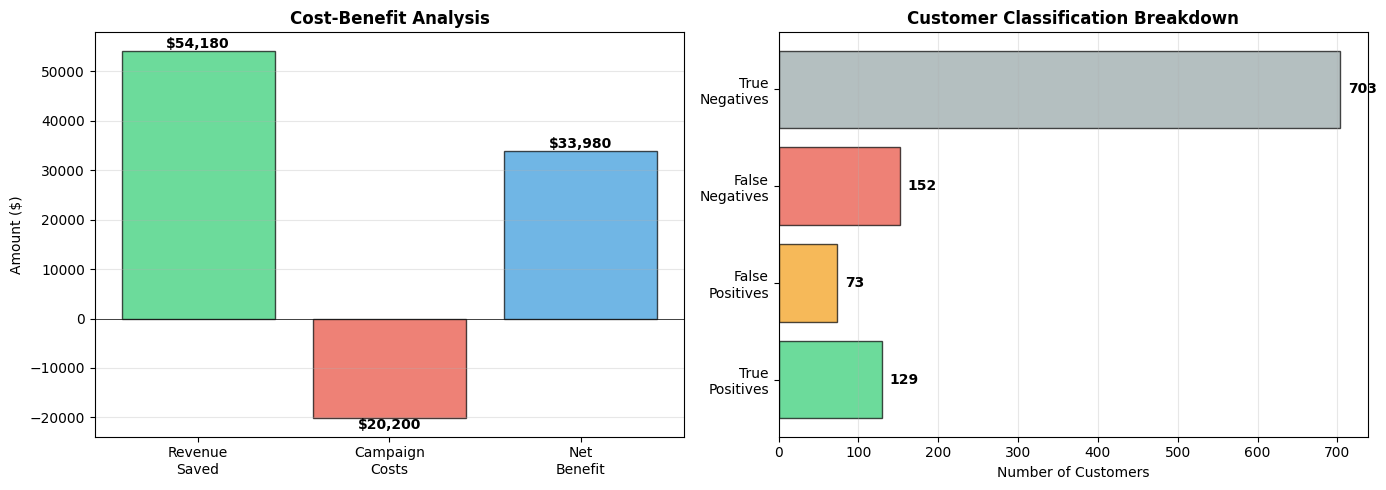

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Business parameters (hypothetical)
avg_customer_lifetime_value = 1200  # Average LTV per customer
retention_campaign_cost = 100       # Cost per targeted customer
retention_success_rate = 0.35       # 35% retained among predicted churners

cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = cm.ravel()

print('=== Confusion Matrix Breakdown ===')
print(f'True Negatives (Correctly predicted no churn): {tn}')
print(f'False Positives (Predicted churn, actually stayed): {fp}')
print(f'False Negatives (Predicted no churn, actually churned): {fn}')
print(f'True Positives (Correctly predicted churn): {tp}')

# Business metrics
customers_targeted = tp + fp
wasted_campaigns = fp
missed_opportunities = fn

customers_saved = tp * retention_success_rate
revenue_saved = customers_saved * avg_customer_lifetime_value

campaign_costs = customers_targeted * retention_campaign_cost

customers_lost = fn + (tp * (1 - retention_success_rate))
revenue_lost = customers_lost * avg_customer_lifetime_value

net_benefit = revenue_saved - campaign_costs

print(f'\n=== Business Impact Analysis ===')
print(f'Customers Targeted for Retention: {customers_targeted}')
print(f'Estimated Customers Saved: {customers_saved:.1f}')
print(f'Revenue Saved: ${revenue_saved:,.2f}')
print(f'Campaign Costs: ${campaign_costs:,.2f}')
print(f'Revenue Lost (Missed + Failed Retention): ${revenue_lost:,.2f}')
print(f'\n💰 Net Benefit: ${net_benefit:,.2f}')
if campaign_costs > 0:
    print(f'📊 ROI: {(net_benefit / campaign_costs * 100):.1f}%')

# Visualize business impact
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Cost-Benefit breakdown
categories = ['Revenue\nSaved', 'Campaign\nCosts', 'Net\nBenefit']
values = [revenue_saved, -campaign_costs, net_benefit]
colors = ['#2ecc71', '#e74c3c', '#3498db']

bars = ax[0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax[0].set_ylabel('Amount ($)')
ax[0].set_title('Cost-Benefit Analysis', fontsize=12, fontweight='bold')
ax[0].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2., height,
               f'${abs(height):,.0f}',
               ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# Customer classification breakdown
customer_categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives', 'True\nNegatives']
customer_counts = [tp, fp, fn, tn]
category_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#95a5a6']

bars2 = ax[1].barh(customer_categories, customer_counts, color=category_colors, alpha=0.7, edgecolor='black')
ax[1].set_xlabel('Number of Customers')
ax[1].set_title('Customer Classification Breakdown', fontsize=12, fontweight='bold')
ax[1].grid(axis='x', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars2, customer_counts)):
    ax[1].text(count + 10, i, f'{count}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()
